## 0. Loading file


In [ ]:
!rm winequality*
!wget https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv

rm: cannot remove 'winequality*': No such file or directory
--2021-10-30 16:28:10--  https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [text/plain]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.002s  

2021-10-30 16:28:10 (40.7 MB/s) - ‘winequality-red.csv’ saved [84199/84199]



In [ ]:
import pandas as pd
import io
df_red = pd.read_csv('winequality-red.csv', sep=';')

df_red.shape

(1599, 12)

I check if there is any non-numerical element in both dataframes.

In [ ]:
df_red.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [ ]:
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Doubt: Why do I remove the quality column?

In [ ]:
exclude = ['quality']
df_red_1 = df_red.loc[:, df_red.columns.difference(exclude)]

We can visualize the correlation among features, and as shown below we have several features with very low correlation between them. This means that we won't be reducing many dimensions as we aim to keep a high variance value and thus mantain most of the information.

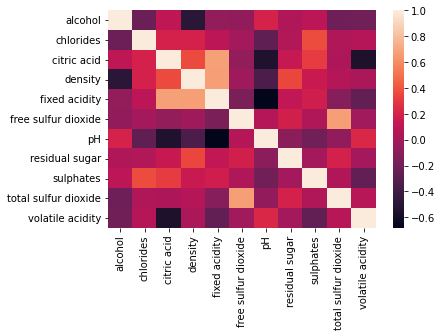

In [ ]:
import seaborn as sns

mtx_corr = df_red_1.corr()
sns.heatmap(mtx_corr, xticklabels=mtx_corr.columns, yticklabels=mtx_corr.columns, annot=False)

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
wines = scaler.fit_transform(df_red_1)

We now apply PCA to reduce some components. As I mentioned before, I will not reduce many dimensions to avoid loss of major information.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(wines)
X_pca.shape

(1599, 11)

In [ ]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[3.10107182 1.92711489 1.55151379 1.21399175 0.95989238 0.66002104
 0.58415655 0.42322138 0.34485779 0.18144664 0.05959558]
[0.28173931 0.1750827  0.1409585  0.11029387 0.08720837 0.05996439
 0.05307193 0.03845061 0.0313311  0.01648483 0.00541439]
[0.28173931 0.45682201 0.59778051 0.70807438 0.79528275 0.85524714
 0.90831906 0.94676967 0.97810077 0.99458561 1.        ]


If we look at the graph we can see that around 90% of the information is kept if we choose to reduce the components to 7. 6 components would result in around 85% of the information, so I'll go on with 7 components.

In [ ]:
import plotly.express as px
import numpy as np

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x = range(1, exp_var_cumul.shape[0] + 1),
    y = exp_var_cumul,
    labels = {"x": "# Components", "y": "Explained Variance"}
)

We can now see how each component is correlated with every feature.

In [ ]:
import numpy
pca = PCA(n_components=7)
X_pca = pca.fit_transform(wines)

pd.DataFrame(numpy.matrix.transpose(pca.components_), columns=[f'PC-{i}' for i in range(7)], index=df_red_1.columns)

,PC-0,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
alcohol,-0.113232,-0.386181,0.471673,-0.122181,0.350681,0.361645,-0.327651
chlorides,0.212247,0.148052,-0.092614,0.666195,0.246501,0.304339,0.370413
citric acid,0.463632,-0.151791,0.238247,-0.079418,-0.058573,0.069593,0.105497
density,0.395353,0.233575,-0.338871,-0.174500,0.157077,-0.391152,-0.170481
fixed acidity,0.489314,-0.110503,-0.123302,-0.229617,-0.082614,0.101479,-0.350227
free sulfur dioxide,-0.036158,0.513567,0.428793,-0.043538,-0.159152,-0.014000,-0.116596
pH,-0.438520,0.006711,0.057697,-0.003788,0.267530,-0.522116,-0.025138
residual sugar,0.146107,0.272080,0.101283,-0.372793,0.732144,0.049156,0.290663
sulphates,0.242921,-0.037554,0.279786,0.550872,0.225962,-0.381263,-0.447469
total sulfur dioxide,0.023575,0.569487,0.322415,-0.034577,-0.222465,0.136308,-0.093662


I now have an explained variance of 0.456822 using the first two principal components, so I am losing around 55% of the information, which is a considerable amount. 

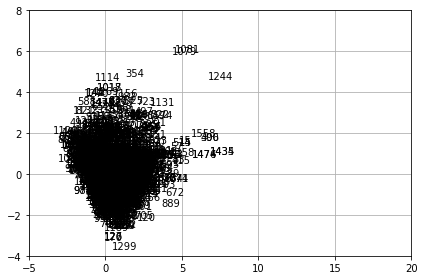

In [ ]:
#3.  plot 
import matplotlib.pyplot as plt
import numpy
numbers = numpy.arange(len(X_pca))
fig, ax = plt.subplots()
for i in range(len(X_pca)):
    plt.text(X_pca[i][1], X_pca[i][2], numbers[i]) 
# be careful with xlim and ylim
plt.xlim(-5, 20)
plt.ylim(-4, 8)
ax.grid(True)
fig.tight_layout()
plt.show()

Some outliers are detectable here, but the most of the samples are grouped in a big single cluster.

# K-MEANS


In [ ]:
#parameters

init = 'random'
iterations = 10
max_iter = 300
tol = 1e-04
random_state = 0

I am going to choose the number of clusters K after the evaluation of the silhouettes and distortion. I do this so I can get the best number of clusters based on the maximum silhouette while the distortion or SSE is minimum.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []

for i in range(2, 11):
  km = KMeans(i, init, n_init=iterations, max_iter = max_iter, tol=tol, random_state=random_state)
  labels = km.fit_predict(X_pca)
  distortions.append(km.inertia_)
  silhouettes.append(metrics.silhouette_score(X_pca, labels))


Now that we have the distortions and the silhouettes, we need to choose the point where silhouette is maximized and the distortion is minimized.
We will plot them both for visualization ease.

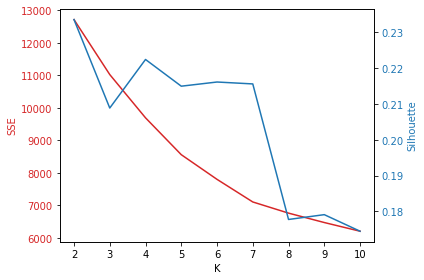

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(2, 11)] #X is the number of clusters from 2 to 11.
fig, ax1 = plt.subplots()

#We graph the distortion 
color = 'tab:red'
ax1.set_xlabel('K')
ax1.set_ylabel('SSE', color = color)
ax1.plot(x, distortions, color = color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Silhouette', color = color)
ax2.plot(x, silhouettes, color = color)
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()
plt.show()


Observing the graph we can set k to 7 as we have the maximum silhouette for the minimum SSE. Another viable point is in k=4, where the total maxium silhouette is reached but with a considerable distortion, so the results wont be as reliable as with k=7.
Now we can proceed to execute the algorithm.

In [ ]:
k = 7
km = KMeans(k, init, n_init=iterations, max_iter = max_iter, tol = tol, random_state=random_state)

y_km = km.fit_predict(X_pca)

from sklearn import metrics
print("Silhouette Coefficient: %0.3f"%metrics.silhouette_score(X_pca, y_km))

print('Distortion: %0.2f' % km.inertia_)


Silhouette Coefficient: 0.216
Distortion: 7107.27


Doubt: Is there a perfect value for Silhouette or for the Distortion?

In [ ]:
import plotly.express as px
fig = px.scatter(x=X_pca[:,0], y = X_pca[:,1], color = km.labels_)

for i in range(0, len(X_pca)):
  fig.add_annotation(x = X_pca[i, 0], y = X_pca[i, 1])

fig.show()

We can see now all the samples divided in 7 groups. 

In [ ]:
df_red_1['kmeans_group'] = km.labels_
df_red_1.groupby('kmeans_group').describe()

alcohol                            ... volatile acidity                     
               count       mean       std  min  ...              25%    50%     75%   max
kmeans_group                                    ...                                      
0              499.0   9.885438  0.575650  9.0  ...           0.5400  0.630  0.7125  1.58
1              184.0  11.738134  0.935938  9.9  ...           0.5000  0.580  0.6700  1.09
2               28.0   9.496429  0.404129  9.0  ...           0.4375  0.490  0.6350  0.78
3              238.0  11.534874  0.801056  8.7  ...           0.2800  0.340  0.4000  0.58
4              328.0   9.808638  0.588302  8.5  ...           0.4275  0.550  0.6300  1.24
5               46.0  10.086957  0.990759  8.8  ...           0.4225  0.495  0.6300  0.90
6              276.0  10.439372  0.983169  8.4  ...           0.3400  0.400  0.4900  0.89

[7 rows x 88 columns]

As shown above, the biggest cluster is the number 0 with 499 samples while the smallest one counts with 28 samples. 

Doubt: I dont really know how to interpret the results, what should i look for? Should I do any other graphs? Is the table above actually useful?
